## Segmentation, extracting plate and OCR (one image)

In [205]:
# Load the image
# img_path = "KA7777XK.jpg"
# img_path = "KE7777HT.jpg"
# img_path = "KA7777AC.jpg"
img_path = "KA7777CA.jpg"
# img_path = "AB3747BC.jpeg"
# img_path = "AO1467BH.jpeg"
# img_path = "AA8168YA.jpg"
# img_path = "AE1455KH_3.jpg"
# img_path = "AE1455KH_4.jpg"
# img_path = "KA3713EX.jpg"
# img_path = "KA3792KK.jpg"
# img_path = "KA2014EX.jpg"
# img_path = "KA6003EK.jpg"
img_path = "KA8781IO.jpg"
# img_path = "UVVI8I.jpg"
# img_path = "BUBO4KA.jpg"
# img_path = "AE1455KH_2.jpg"
# img_path = "AI2866YA.jpg"
# img_path = "KA1088IO.jpg"
# img_path = "KA2803IT.jpg"
# img_path = "PYTHON.jpg"
# img_path = "PYTHON_2.jpg"
# img_path = "AE1455KH.jpg"
# img_path = "AE3591IT.jpg"
# img_path = "A00001A.jpg"
# img_path = "AE7094HC.jpg"
# img_path = "AR024MI.jpg"
# img_path = "AM3808CO.jpg"
# img_path = "HH0001OO.jpg"
# img_path = "KE3198AE.jpeg"
# img_path = "SN66XMZ.jpg"
# img_path = "BT5390BM.jpg"

In [206]:
# !pip3 install paddlepaddle
# !pip3 install paddleocr
import cv2
from paddleocr import PaddleOCR
import re
import os
import matplotlib.pyplot as plt
import numpy as np

In [207]:
# Initialize PaddleOCR with English language model
ocr = PaddleOCR(
    use_angle_cls=True,
    lang="en",
    use_gpu=True,
    total_process_num=os.cpu_count() * 2 - 1,
    show_log=False,
)

In [208]:
# Load pre-trained license plate cascade classifier
plate_cascade = cv2.CascadeClassifier("../models/haarcascade_ua_license_plate.xml")

     Функції находження номеру та його сегментації 

In [209]:
def segment_characters(image):

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 6, LP_WIDTH / 2, LP_HEIGHT / 10, 2 * LP_HEIGHT / 3]
    plt.imshow(img_binary_lp, cmap="gray")
    plt.axis("off")
    plt.show()
    
    cv2.imwrite("../images/contour.jpg", img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


# Match contours to license plate or character template
def find_contours(dimensions, img):

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread("../images/contour.jpg")

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if (
            intWidth > lower_width
            and intWidth < upper_width
            and intHeight > lower_height
            and intHeight < upper_height
        ):
            x_cntr_list.append(
                intX
            )  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY : intY + intHeight, intX : intX + intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(
                ii, (intX, intY), (intWidth + intX, intY + intHeight), (76, 202, 102), 2
            )
            plt.imshow(ii, cmap="gray")

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(
                char_copy
            )  # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.axis("off")
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(
            img_res[idx]
        )  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


def detect_plate(img, text=""):
    plate_img = img.copy()
    roi = img.copy()
    plate = None  # Initialize plate with a default value
    plate_rect = plate_cascade.detectMultiScale(
        plate_img, scaleFactor=1.6, minNeighbors=8
    )
    for x, y, w, h in plate_rect:
        roi_ = roi[y : y + h, x : x + w, :]
        plate = roi[y : y + h, x : x + w, :]
        cv2.rectangle(
            plate_img, (x - 15, y), (x + w - 3, y + h - 5), (179, 206, 226), 3
        )
    if text != "" and plate is not None:
        plate_img = cv2.putText(
            plate_img,
            text,
            (x - w // 2, y - h // 2),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            0.5,
            (179, 206, 226),
            1,
            cv2.LINE_AA,
        )

    return plate_img, plate

     Функції обробки тексту, що розпізнано 

In [210]:
# позиційна обробка ["1", "0", "7", '8'] <-> ["I", "O", "Z", 'B']
def clean_ua_number(text):
    if len(text) == 8:
        text_list = list(text)

        for i in [0, 1, 6, 7]:
            text_list[i] = (
                text_list[i]
                .replace("1", "I")
                .replace("i", "I")
                .replace("0", "O")
                .replace("7", "Z")
                .replace("8", "B")
            )

        for i in [2, 3, 4, 5]:
            text_list[i] = (
                text_list[i]
                .replace("I", "1")
                .replace("i", "1")
                .replace("O", "0")
                .replace("Z", "7")
                .replace("B", "8")
            )

        text = "".join(text_list)
    return text


# Validate Ukrainian plate format
def validate_ukraine_plate(text):
    pattern = r"^[A-Z]{2}\d{4}[A-Z]{2}$"
    return bool(re.match(pattern, text))

In [211]:
# обробка тексту, що розпізнано на номері
def processing_number_text(result):
    text_up = ""
    for line in result:

        for word in line:

            text = clean_ua_number(
                word[1][0].strip().replace("\n", "").replace(" ", "")
            )

            # для американських номерів - в 2 ряди
            if re.match(r"^[A-Z]{4}$", text):
                text_up = text
            elif re.match(r"^\d{4}$", text) and re.match(r"^[A-Z]{4}$", text_up):
                text = text_up[:2] + text + text_up[2:]
                text_up = ""

            if re.match(r"^[A-Z0-9]+$", text):
                if validate_ukraine_plate(text):
                    print(f"Detected License Plate: \033[33m{text}\033[0m")
                else:
                    print(f" Invalid License Plate: \033[31m{text}\033[0m")
    return text

In [212]:
# Extract license plate text using PaddleOCR
def extract_license_plate_text(image_path):

    # OCR debug - сірим кольором
    print("\033[90m", end="")
    result = ocr.ocr(image_path)
    print("\033[0m", end="")

    return processing_number_text(result)

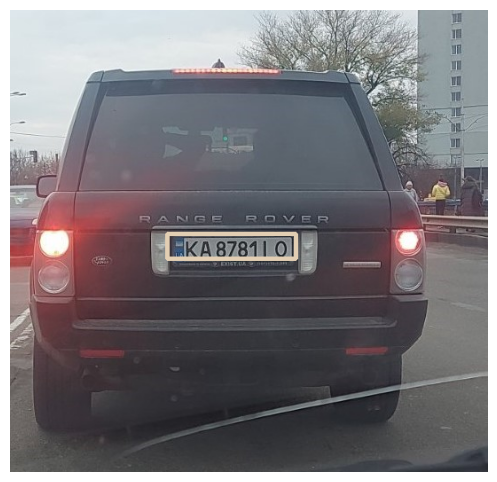

License plate detected.


In [213]:
img = cv2.imread("../images/" + img_path)

# Detect the plate
output_img, plate = detect_plate(img)

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

if plate is not None:
    print("License plate detected.")
else:
    print("No license plate detected.")

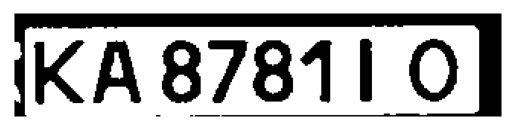

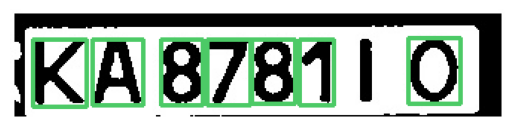

In [214]:
char = segment_characters(plate)

In [215]:
extract_license_plate_text("../images/contour.jpg")

Detected License Plate: KA8781IO


'KA8781IO'